# Project_3

In [ ]:
#importing packages
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### Data loading

In [ ]:
#reading dataframe
data = pd.read_csv('AirQualityUCI.csv', sep = ';')

In [ ]:
data.head()

Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    122.0        1584.0       1203.0  11,0  60,0   
4    131.0        1205.0    116.0        1490.0       1110.0  11,2  59,6   

       AH  Unnamed: 15  Unnamed: 16  
0  0,7578          NaN          NaN  
1  0,7255          NaN          NaN  
2  0,7502          NaN          NaN  
3  0,7867          NaN          NaN  
4  0,7888          NaN          NaN

In [ ]:
data.shape

(9471, 17)

From here we can see that dataframe has 9471 rows and 17 columns (features).

In [ ]:
#Formatting Date and Time to datetime type
data['Time'] = pd.to_datetime(data['Time'],format= '%H.%M.%S' ).dt.time
data['Time']=data['Time'].astype(str)

In [ ]:
#converting date and time to datetime
data['Datetime']=data.Date+' '+data.Time
data['Time']=pd.to_datetime(data.Datetime)
data.dtypes

Date                     object
Time             datetime64[ns]
CO(GT)                   object
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                 object
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                        object
RH                       object
AH                       object
Unnamed: 15             float64
Unnamed: 16             float64
Datetime                 object
dtype: object

In [ ]:
#removing features date and datetime
data.drop('Date', axis=1, inplace=True)
data.drop('Datetime', axis=1, inplace=True)

Formatting some object columns from strings to floats (columns: CO(GT), C6H6(GT), T, RH, AH).

In [ ]:
data.replace(to_replace=',',value='.',regex=True,inplace=True)

for i in 'CO(GT) C6H6(GT) T RH AH'.split():
    data[i] = pd.to_numeric(data[i],errors='coerce')

Replacing null data from -200 to NaN for posterior treatment.

In [ ]:
data.replace(to_replace=-200,value=np.nan,inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           9357 non-null   datetime64[ns]
 1   CO(GT)         7674 non-null   float64       
 2   PT08.S1(CO)    8991 non-null   float64       
 3   NMHC(GT)       914 non-null    float64       
 4   C6H6(GT)       8991 non-null   float64       
 5   PT08.S2(NMHC)  8991 non-null   float64       
 6   NOx(GT)        7718 non-null   float64       
 7   PT08.S3(NOx)   8991 non-null   float64       
 8   NO2(GT)        7715 non-null   float64       
 9   PT08.S4(NO2)   8991 non-null   float64       
 10  PT08.S5(O3)    8991 non-null   float64       
 11  T              8991 non-null   float64       
 12  RH             8991 non-null   float64       
 13  AH             8991 non-null   float64       
 14  Unnamed: 15    0 non-null      float64       
 15  Unnamed: 16    0 non-

I will check the number of missing values in the dataset.

In [ ]:
data.isnull().sum()

Time              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

The column NMHC (GT) seems to have a lot of misplaced data; unnamed:15 and unnamed: 16 have all missing values, so I decided to drop these features. Also I will drop all duplicates.

In [ ]:
data.drop('NMHC(GT)', axis=1, inplace=True)
data.drop(['Unnamed: 15','Unnamed: 16'], axis = 1, inplace = True)
data.drop_duplicates(inplace= True)
data.head()

Time  CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0 2004-10-03 18:00:00     2.6       1360.0      11.9         1046.0    166.0   
1 2004-10-03 19:00:00     2.0       1292.0       9.4          955.0    103.0   
2 2004-10-03 20:00:00     2.2       1402.0       9.0          939.0    131.0   
3 2004-10-03 21:00:00     2.2       1376.0       9.2          948.0    172.0   
4 2004-10-03 22:00:00     1.6       1272.0       6.5          836.0    131.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.7578  
1        1174.0     92.0        1559.0        972.0  13.3  47.7  0.7255  
2        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.7502  
3        1092.0    122.0        1584.0       1203.0  11.0  60.0  0.7867  
4        1205.0    116.0        1490.0       1110.0  11.2  59.6  0.7888

Below, I choose to fill in the missing values using the median_filling function, which fills in the missing values with median using group by "Time" feature.

In [ ]:
def median_filling(col):
    data[col] = data.groupby('Time')[col].transform(lambda x:x.fillna(x.median()))

In [ ]:
#filing empty cells with the median
col_list = data.columns[1:12]

for i in col_list:
    median_filling(i)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9358 entries, 0 to 9357
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           9357 non-null   datetime64[ns]
 1   CO(GT)         7674 non-null   float64       
 2   PT08.S1(CO)    8991 non-null   float64       
 3   C6H6(GT)       8991 non-null   float64       
 4   PT08.S2(NMHC)  8991 non-null   float64       
 5   NOx(GT)        7718 non-null   float64       
 6   PT08.S3(NOx)   8991 non-null   float64       
 7   NO2(GT)        7715 non-null   float64       
 8   PT08.S4(NO2)   8991 non-null   float64       
 9   PT08.S5(O3)    8991 non-null   float64       
 10  T              8991 non-null   float64       
 11  RH             8991 non-null   float64       
 12  AH             8991 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 1023.5 KB


From here we can see that there are still missing values, so I choose to use the ffill method - replace values with the value from the previous row.

In [ ]:
data.fillna(method='ffill', inplace= True)

In [ ]:
data.isnull().sum()

Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

I checked if there were any missing values ​​- there are no missing values.

#### Dealing with ouliers

In [ ]:
data.describe()

CO(GT)  PT08.S1(CO)     C6H6(GT)  PT08.S2(NMHC)      NOx(GT)  \
count  9358.000000  9358.000000  9358.000000    9358.000000  9358.000000   
mean      2.082208  1102.726972    10.190575     942.559414   240.733811   
std       1.469723   219.576612     7.565388     269.569125   206.607564   
min       0.100000   647.000000     0.100000     383.000000     2.000000   
25%       1.000000   938.250000     4.400000     733.000000    97.000000   
50%       1.700000  1062.000000     8.300000     911.000000   174.000000   
75%       2.800000  1237.000000    14.000000    1117.000000   318.000000   
max      11.900000  2040.000000    63.700000    2214.000000  1479.000000   

       PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)            T  \
count   9358.000000  9358.000000   9358.000000  9358.000000  9358.000000   
mean     832.723125   109.421137   1452.979910  1030.488993    18.318444   
std      255.702434    47.223022    347.431664   410.900784     8.822040   
min      322.000000     2.000000    551.000000   221.000000    -1.900000   
25%      654.250000    73.000000   1227.250000   726.000000    11.900000   
50%      807.000000   102.000000   1460.000000   964.000000    17.600000   
75%      967.750000   137.000000   1677.000000  1286.750000    24.300000   
max     2683.000000   340.000000   2775.000000  2523.000000    44.600000   

                RH           AH  
count  9358.000000  9358.000000  
mean     48.813614     1.017327  
std      17.357326     0.404842  
min       9.200000     0.184700  
25%      35.400000     0.726200  
50%      48.900000     0.987500  
75%      61.900000     1.306700  
max      88.700000     2.231000

When I compare the mean and median using this table, I don't see that any attribute has any huge outliers. But, we will see better using next graphs. First I will split continuous columns.

In [ ]:
continuous_columns = []
for column_name in data.columns:
    if data[column_name].dtype == float:
        continuous_columns.append(column_name)

In [ ]:
continuous_columns

['CO(GT)',
 'PT08.S1(CO)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

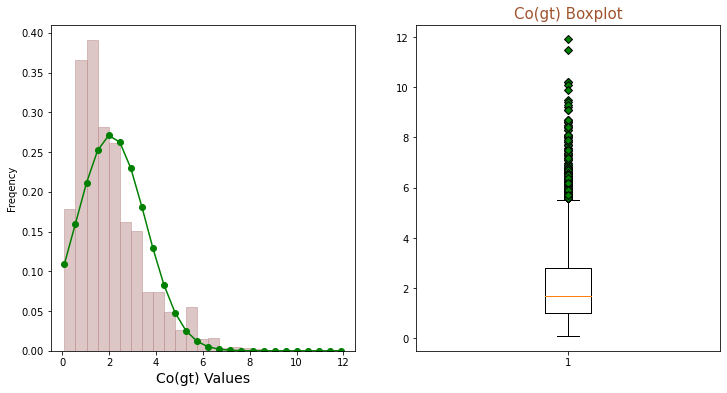

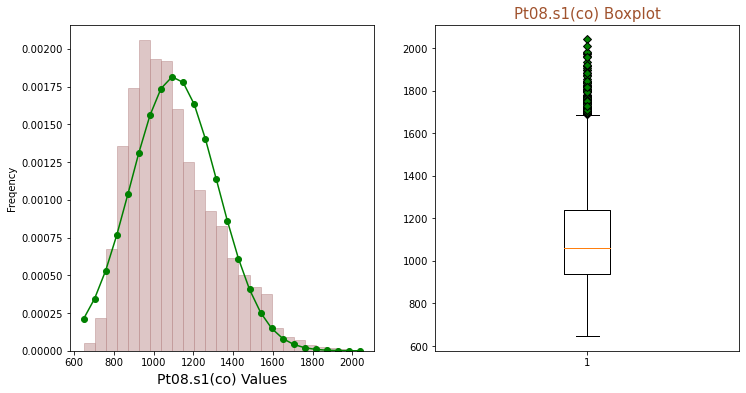

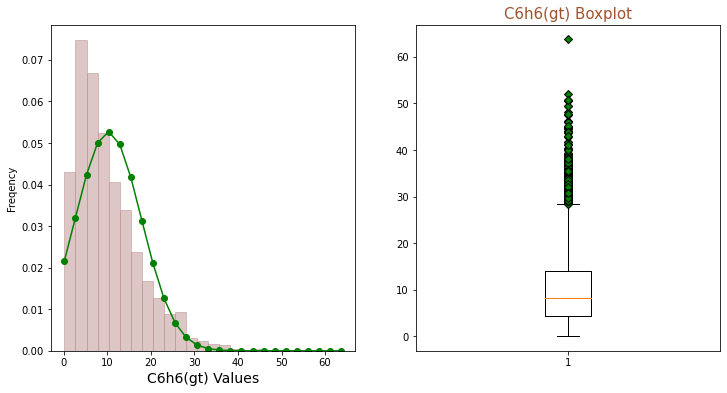

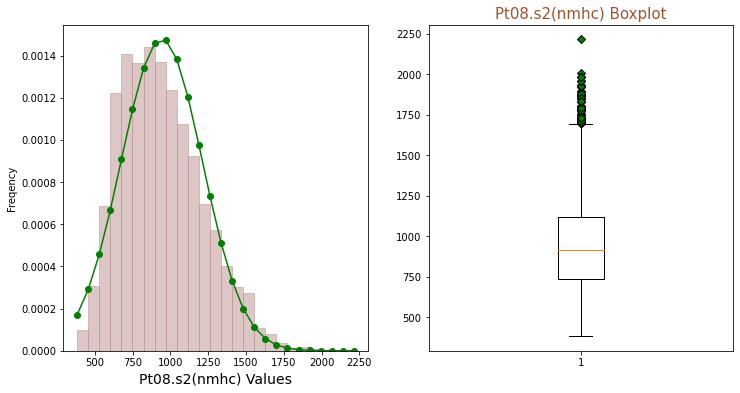

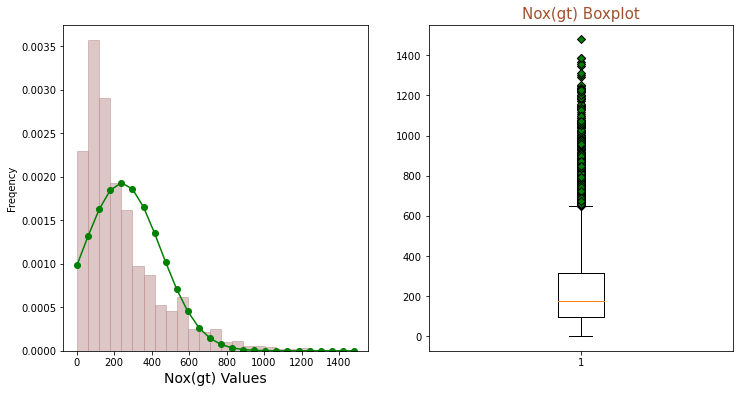

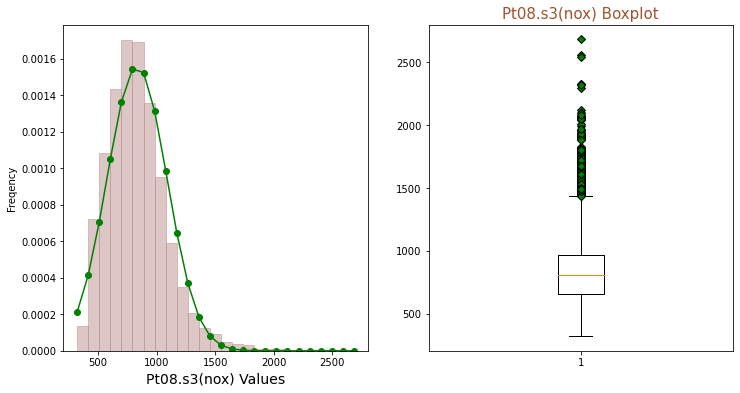

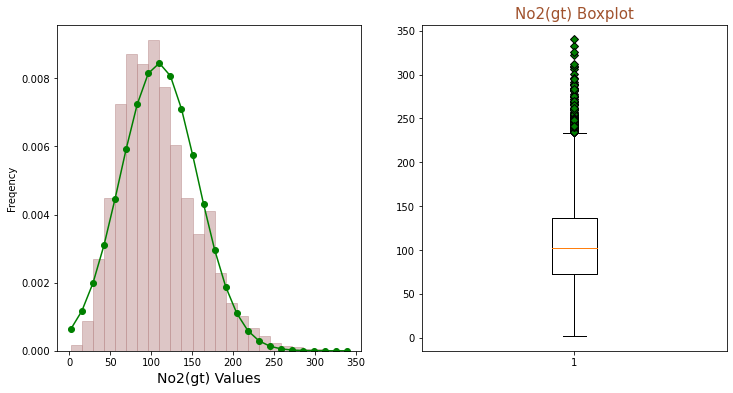

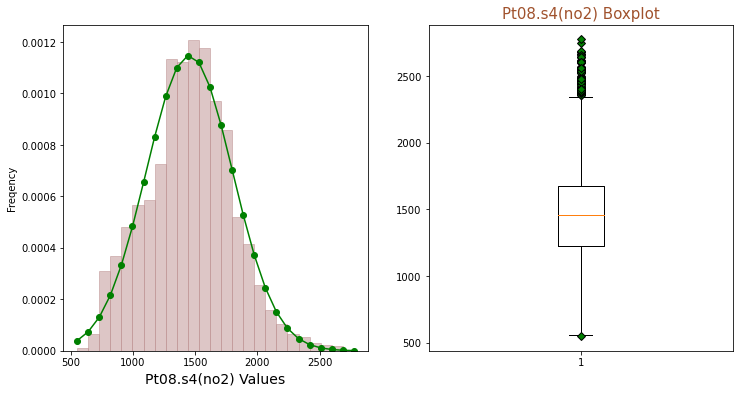

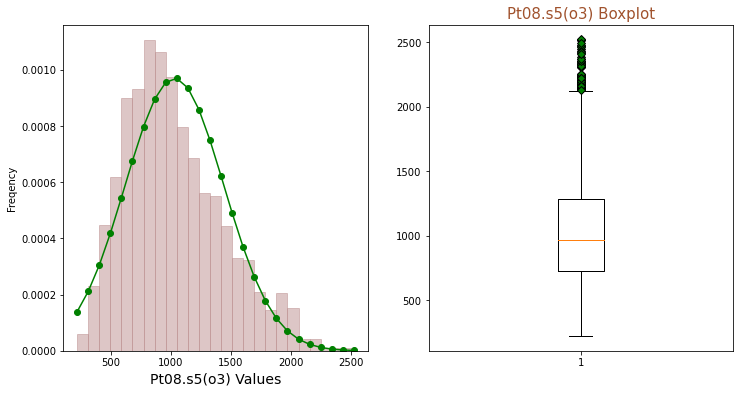

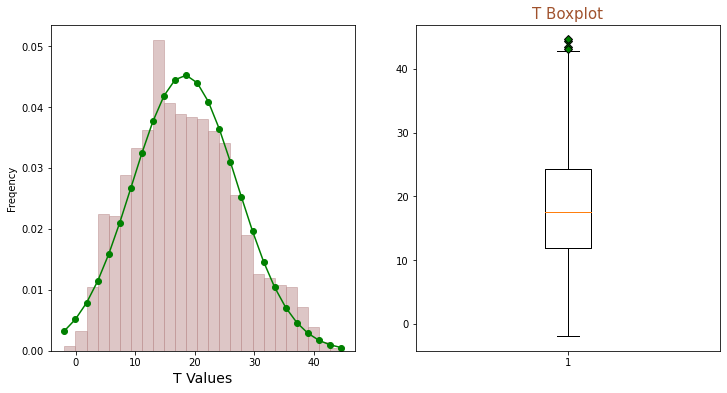

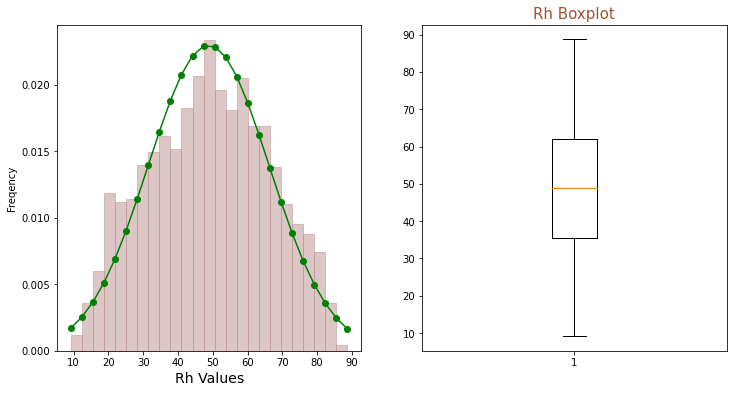

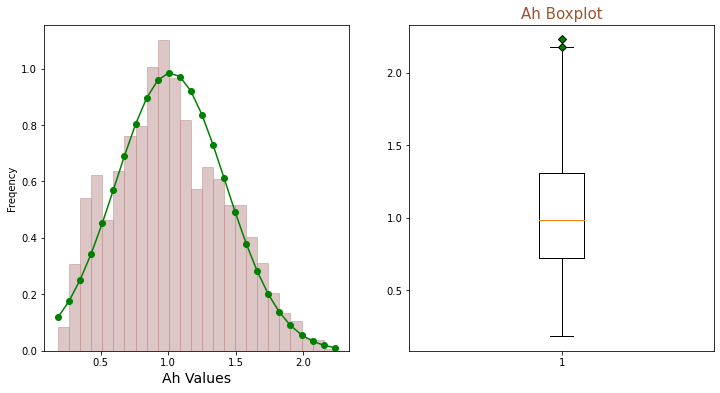

In [ ]:
for column_name in continuous_columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Distribution Num. Feature
    _, bins, _ = ax1.hist(data[column_name], bins = 25,
                          density = 1, alpha = 0.5,
                          color = 'rosybrown',
                          ec= 'rosybrown' )

    mu, sigma = stats.norm.fit(data[column_name])
    best_fit_line = stats.norm.pdf(bins, mu, sigma)

    ax1.plot(bins, best_fit_line, 'g-o')

    ax1.set_ylabel('Freqency')
    ax1.set_xlabel(column_name.capitalize() + " Values",fontsize=14)

    # Boxplot
    green_diamond = dict(markerfacecolor='g', marker='D')
    ax2.boxplot(data[column_name],flierprops=green_diamond)

    ax2.set_title(column_name.capitalize() + " Boxplot",
                  fontdict=dict(
                  family="DejaVu Sans",
                  size=15,
                  color="sienna"))
    plt.show()

From graphs it is obvious that there are some untipical values for some features. The strategy is changing values with 95 - percentile.

In [ ]:
def outliers_modification(data, column):
    for i in range(len(data)):
        if data[column][i] > np.percentile(data[column].unique(), 95):
            data[column][i] = np.percentile(data[column].unique(), 95)
    return data
for column in ["PT08.S3(NOx)", "PT08.S1(CO)", "PT08.S2(NMHC)", "NOx(GT)","NO2(GT)"]:
    data = outliers_modification(data, column)

#### Checking correlation between features

In [ ]:
data.corr()

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
CO(GT)         1.000000     0.759509  0.779056       0.765380  0.785794   
PT08.S1(CO)    0.759509     1.000000  0.883679       0.896251  0.644882   
C6H6(GT)       0.779056     0.883679  1.000000       0.977425  0.636312   
PT08.S2(NMHC)  0.765380     0.896251  0.977425       1.000000  0.624823   
NOx(GT)        0.785794     0.644882  0.636312       0.624823  1.000000   
PT08.S3(NOx)  -0.630967    -0.792913 -0.750544      -0.812822 -0.624111   
NO2(GT)        0.694130     0.583043  0.538868       0.568610  0.766274   
PT08.S4(NO2)   0.512400     0.674857  0.756269       0.769043  0.192412   
PT08.S5(O3)    0.736974     0.901956  0.861661       0.876467  0.710846   
T              0.001526     0.037572  0.189659       0.233509 -0.245725   
RH             0.041948     0.120104 -0.054986      -0.084590  0.185400   
AH             0.023283     0.122174  0.155781       0.174879 -0.143334   

               PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)         T  \
CO(GT)            -0.630967  0.694130      0.512400     0.736974  0.001526   
PT08.S1(CO)       -0.792913  0.583043      0.674857     0.901956  0.037572   
C6H6(GT)          -0.750544  0.538868      0.756269     0.861661  0.189659   
PT08.S2(NMHC)     -0.812822  0.568610      0.769043     0.876467  0.233509   
NOx(GT)           -0.624111  0.766274      0.192412     0.710846 -0.245725   
PT08.S3(NOx)       1.000000 -0.602341     -0.540859    -0.809079 -0.131750   
NO2(GT)           -0.602341  1.000000      0.107970     0.635022 -0.194143   
PT08.S4(NO2)      -0.540859  0.107970      1.000000     0.579208  0.558193   
PT08.S5(O3)       -0.809079  0.635022      0.579208     1.000000 -0.044889   
T                 -0.131750 -0.194143      0.558193    -0.044889  1.000000   
RH                -0.062207 -0.098750     -0.014949     0.137903 -0.570859   
AH                -0.217022 -0.338934      0.630315     0.055548  0.654508   

                     RH        AH  
CO(GT)         0.041948  0.023283  
PT08.S1(CO)    0.120104  0.122174  
C6H6(GT)      -0.054986  0.155781  
PT08.S2(NMHC) -0.084590  0.174879  
NOx(GT)        0.185400 -0.143334  
PT08.S3(NOx)  -0.062207 -0.217022  
NO2(GT)       -0.098750 -0.338934  
PT08.S4(NO2)  -0.014949  0.630315  
PT08.S5(O3)    0.137903  0.055548  
T             -0.570859  0.654508  
RH             1.000000  0.180735  
AH             0.180735  1.000000

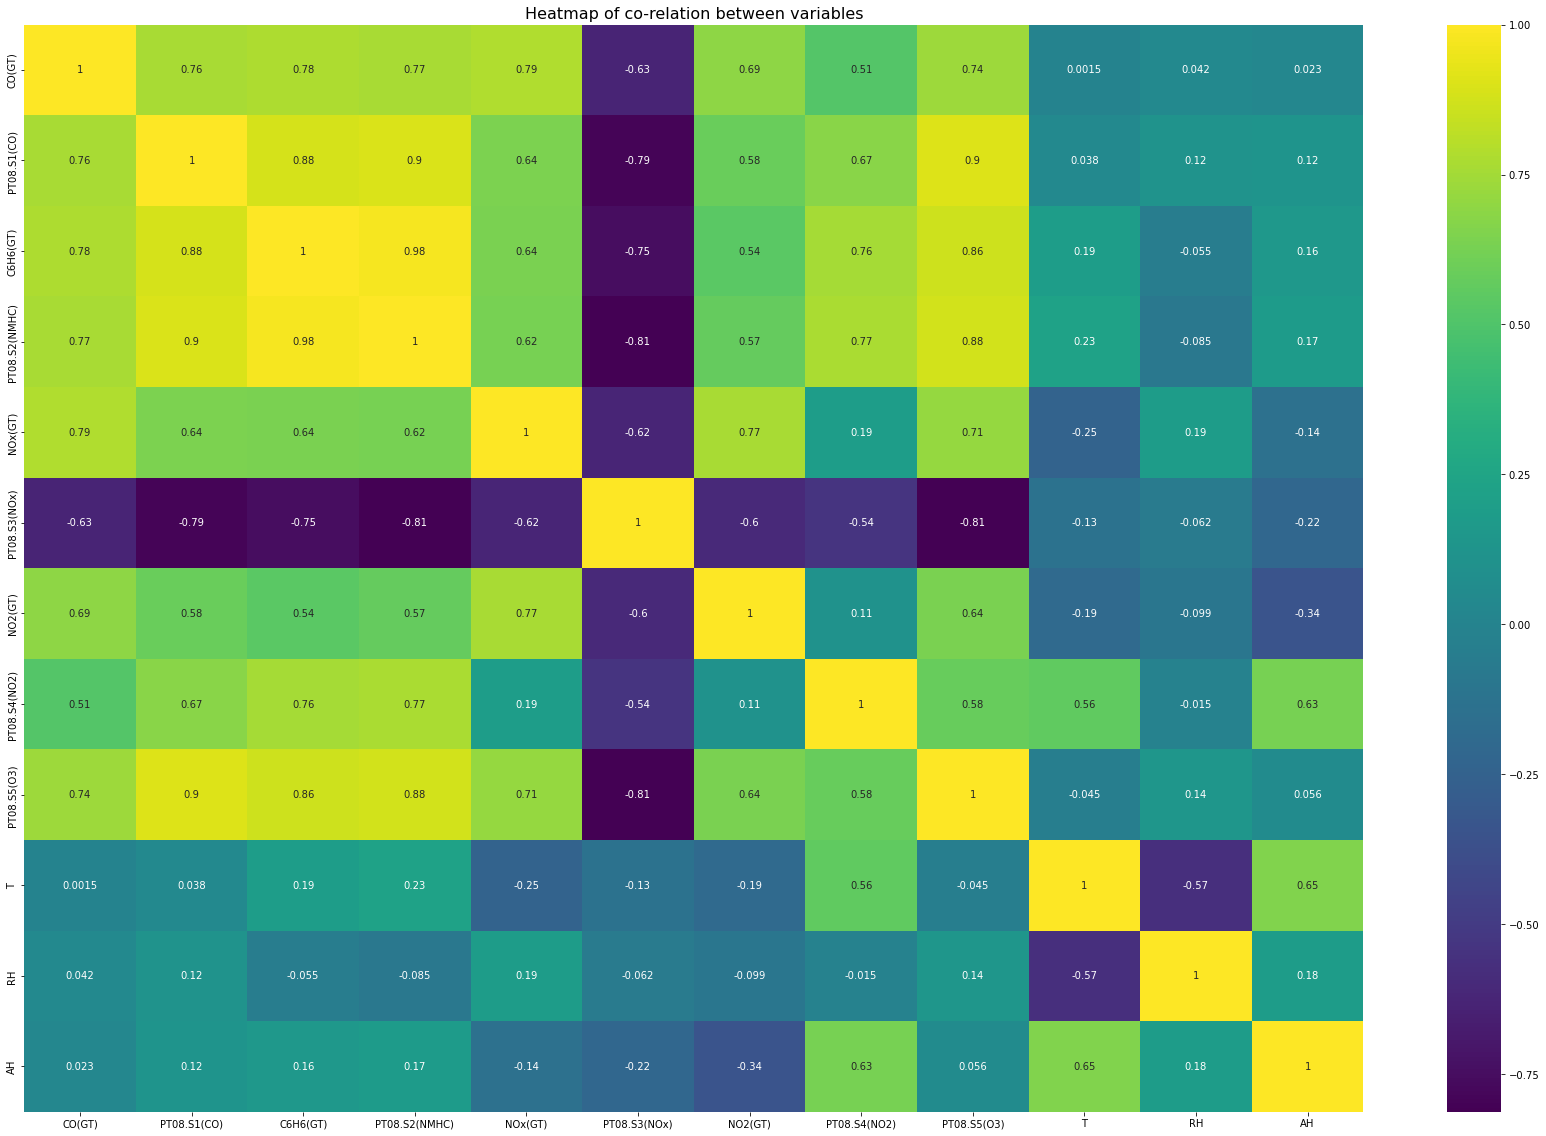

In [ ]:
corrmat=data.corr()
top_corr_feature=corrmat.index
plt.figure(figsize=(30, 20))
plt.title('Heatmap of co-relation between variables',fontsize=16)
graph=sns.heatmap(data[top_corr_feature].corr(), annot=True, cmap='viridis')

From this graph, it can be seen that our target feature C6H6(GT) is highly correlated with the feature PT08.S2(NMHC), but also there is high correlation with PT08.S1(CO)...

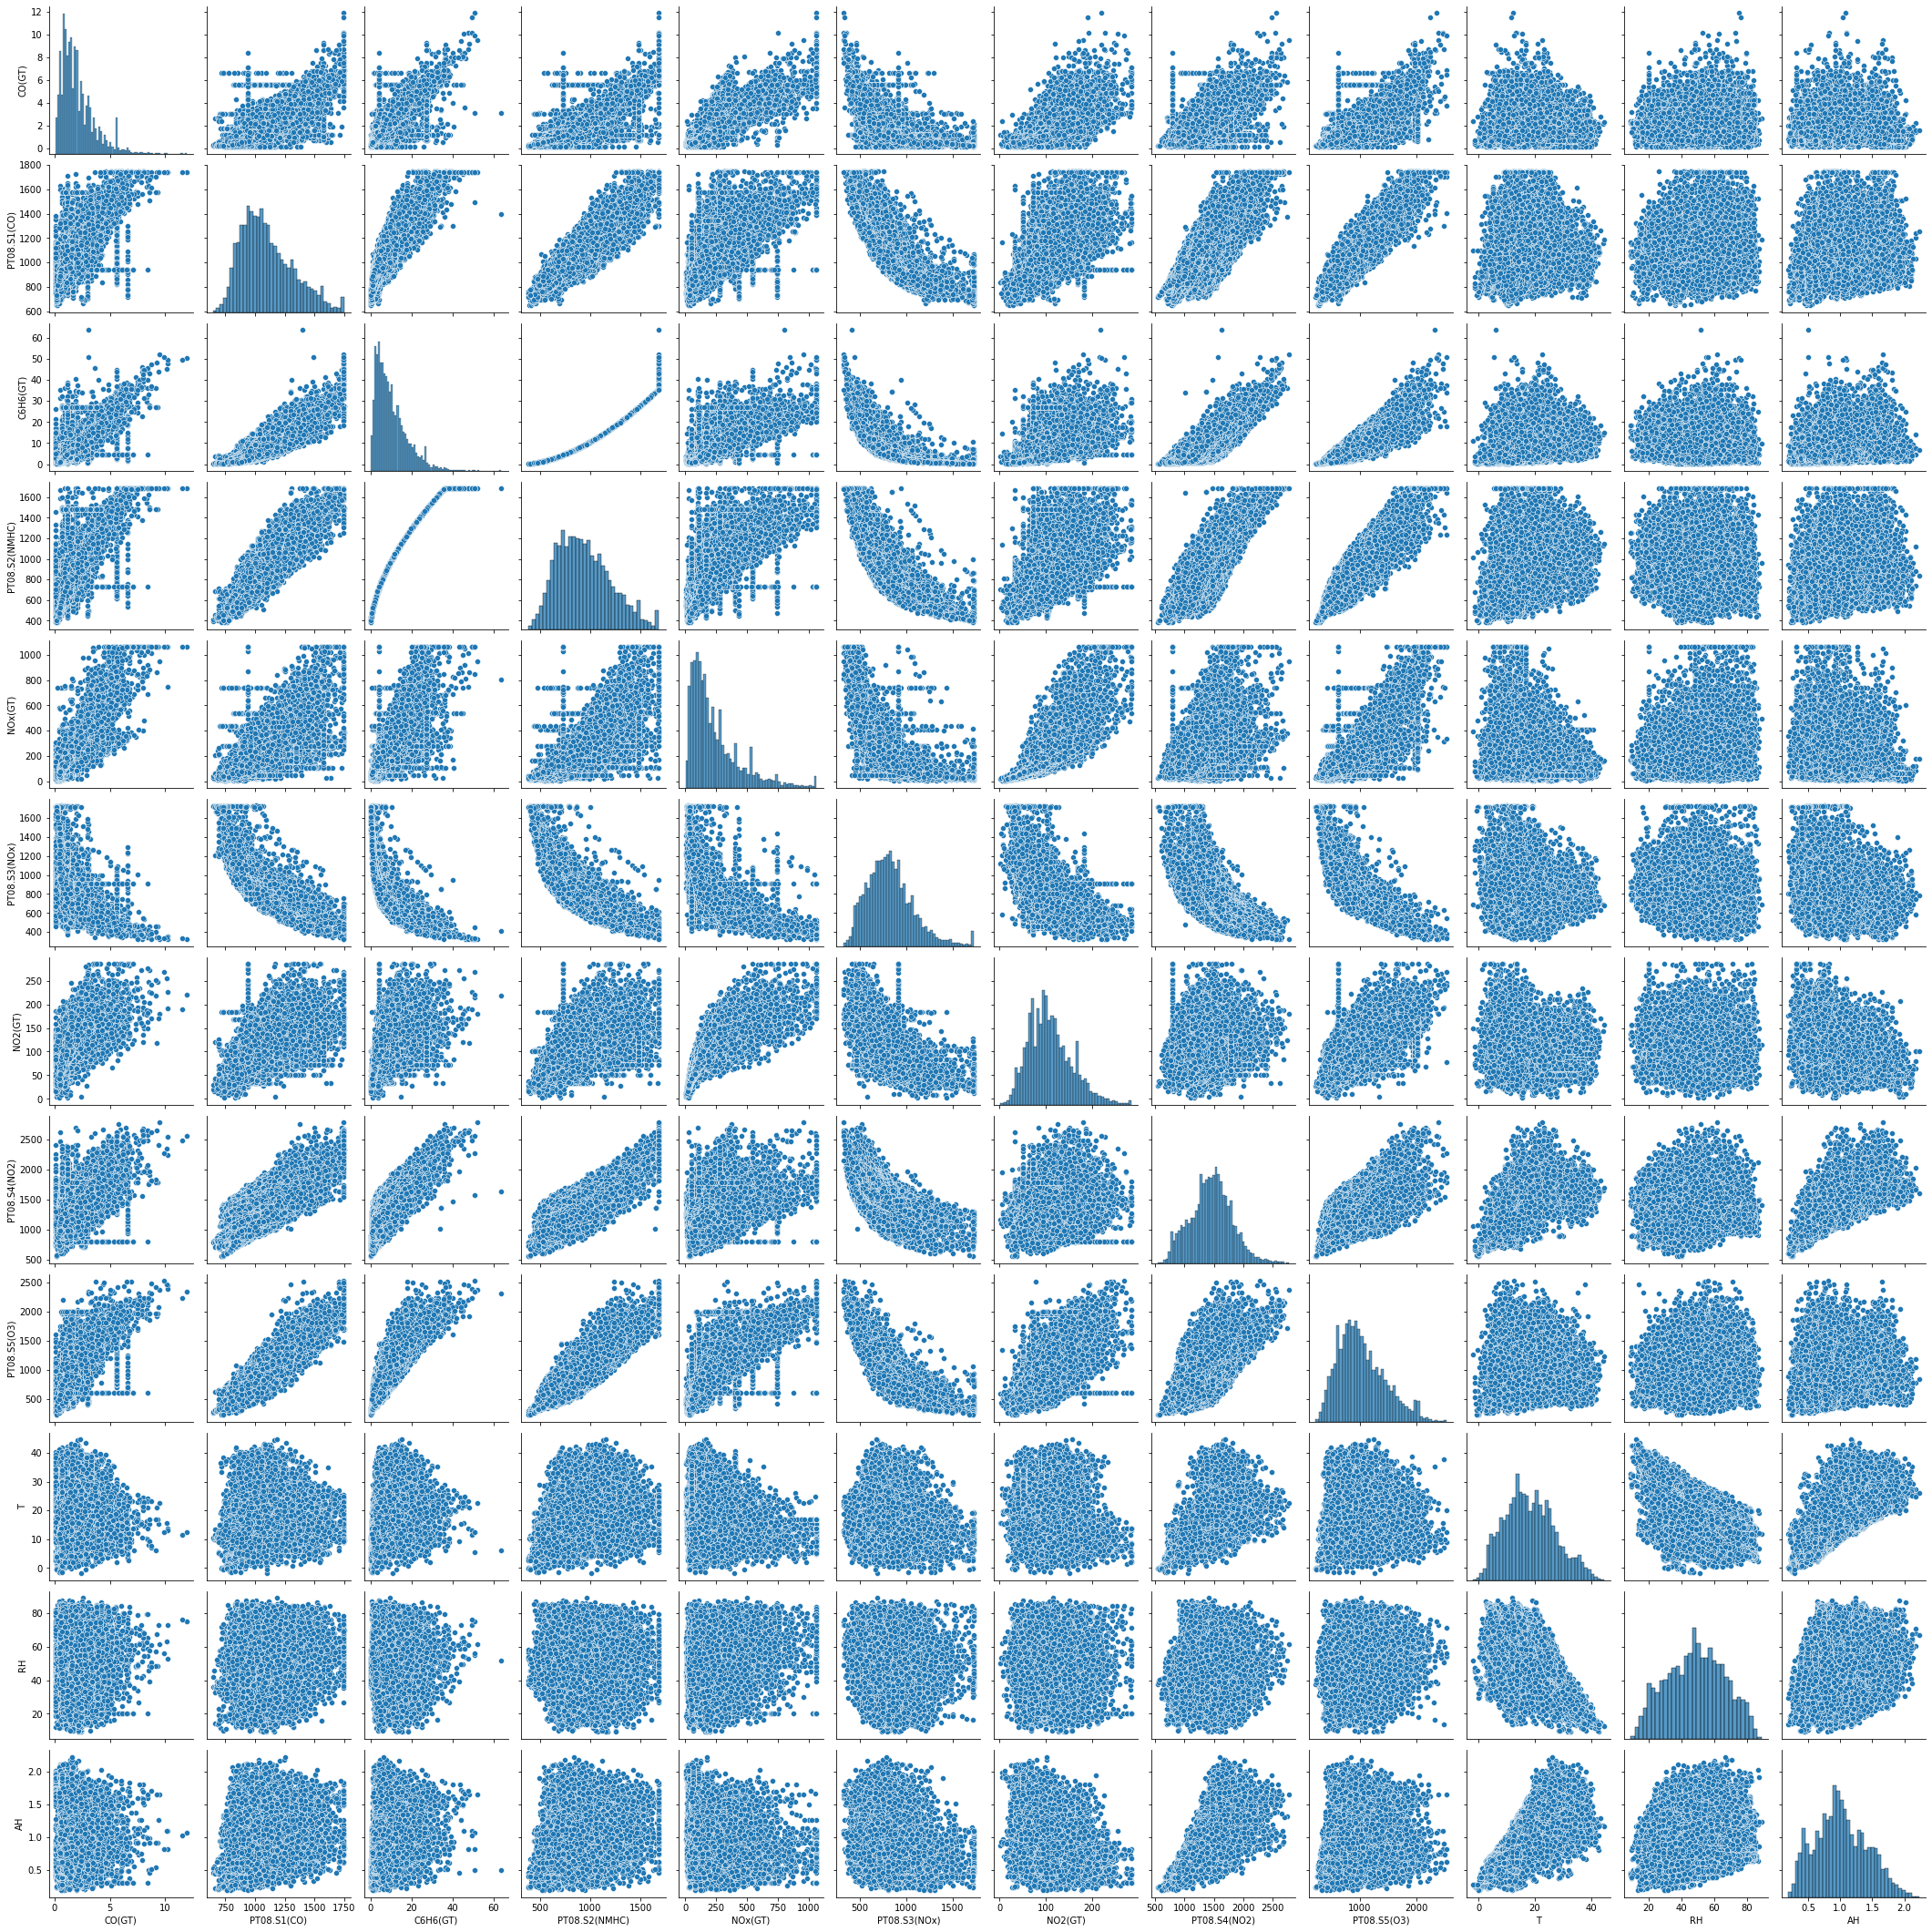

In [ ]:
sns.pairplot(data)

Plot pairwise relationships in a dataset, and we can see again correlations between our features, which features are high correlated and which are not. On next plot, we can see regplot for features C6H6(GT) and PT08.S2(NMHC)

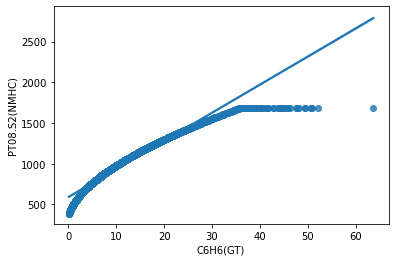

In [ ]:
ax=sns.regplot(x = 'C6H6(GT)', y = 'PT08.S2(NMHC)', data=data)

### Modeling

Creating X - all columns except target column and column `Time`

In [ ]:
X = data
X = X.drop('C6H6(GT)', axis=1)
X = X.drop('Time', axis=1)

Creating Y - target column `C6H6(GT)`

In [ ]:
Y=data['C6H6(GT)']
Y.head()

0    11.9
1     9.4
2     9.0
3     9.2
4     6.5
Name: C6H6(GT), dtype: float64

Splitting into test and train set in the ratio of 20:80

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=42)

It is necessary to scale data. I choose this Scaler bacouse removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method.

In [ ]:
sc=RobustScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

In [ ]:
x_train

array([[-0.44444444, -0.41554054, -0.40234375, ...,  0.73387097,
         0.03044719,  1.22706844],
       [ 0.66666667,  1.18243243,  0.89453125, ...,  0.58870968,
         0.08372978,  1.02298506],
       [-0.27777778, -1.        , -1.15234375, ..., -0.73387097,
        -0.14843007, -0.83910457],
       ...,
       [ 1.05555556,  1.27702703,  1.30078125, ...,  0.40322581,
         0.48334919,  1.15807045],
       [ 1.27777778,  1.2027027 ,  0.96223958, ...,  0.12903226,
        -0.49476689, -0.35183838],
       [ 1.16666667,  1.25      ,  0.73567708, ..., -0.34677419,
         0.28544244, -0.22822412]])

In [ ]:
x_test

array([[ 0.38888889,  0.35135135,  0.05859375, ..., -0.08870968,
         0.25118934,  0.0660874 ],
       [-0.11111111, -0.60135135, -0.23567708, ..., -0.04032258,
        -0.95908658, -0.91614947],
       [-0.27777778, -0.29391892, -0.23567708, ..., -0.73387097,
        -0.19410086, -0.85879382],
       ...,
       [ 2.16666667,  0.01351351, -0.22265625, ...,  0.2016129 ,
         0.65461465,  0.93138724],
       [ 0.38888889, -0.01351351, -0.23046875, ..., -0.28225806,
        -0.10275928, -0.43110902],
       [ 0.11111111,  0.3277027 ,  0.26953125, ...,  0.46774194,
         0.11037108,  0.81462141]])

Text(0.5, 1.0, 'C6H6(GT) distribution')

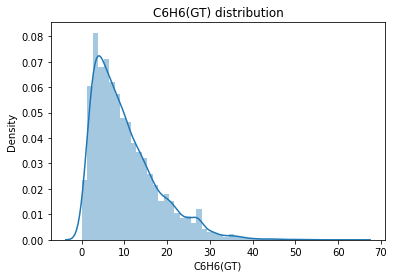

In [ ]:
ax = sns.distplot(y_train, norm_hist = True)
ax.set_title('C6H6(GT) distribution')

Text(0.5, 1.0, 'C6H6(GT) distribution')

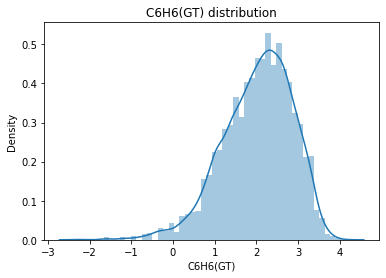

In [ ]:
ax = sns.distplot(np.log(y_train), norm_hist = True)
ax.set_title('C6H6(GT) distribution')

Text(0.5, 1.0, 'C6H6(GT) distribution')

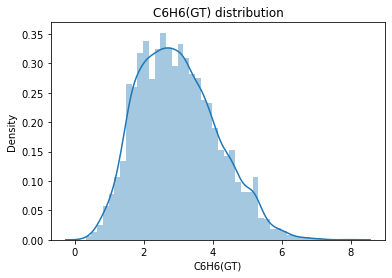

In [ ]:
ax = sns.distplot(np.sqrt(y_train), norm_hist = True)
ax.set_title('C6H6(GT) distribution')

Based on the previous three graphs, I can see that the graph is closest to the normal distribution if the square root is applied to the training data of our target column.

In [ ]:
print('Train data shape: ',x_train.shape, y_train.shape)
print('Test data shape: ',x_test.shape, y_test.shape)

Train data shape:  (7486, 11) (7486,)
Test data shape:  (1872, 11) (1872,)


In [ ]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [ ]:
print('Intercept:',lr.intercept_)

Intercept: 9.061392293177978


In [ ]:
prediction = lr.predict(x_test)
prediction

array([10.00592721,  6.78015068,  6.66112443, ...,  7.44616521,
        7.62492526, 12.1331153 ])

Next plot represents predicted value for target column.

<AxesSubplot:xlabel='C6H6(GT)'>

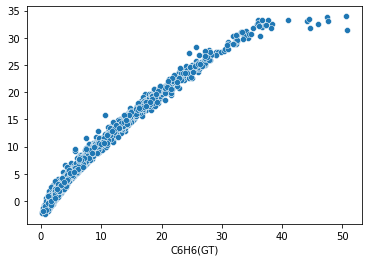

In [ ]:
fig_dims = (6,3.5)
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(y_test,prediction)

As we can see, the predicted values are centered in the linear curve.

In [ ]:
score_test1 = lr.score(x_train, y_train)
score_test1

0.9694997485694697

In [ ]:
score_test = lr.score(x_test, y_test)
score_test

0.9638182667757059

After comparing the score calculated over the train and test data, we can see that the score is almost equal, which indicates that the model did not underfit or overfit.

<AxesSubplot:xlabel='C6H6(GT)', ylabel='Density'>

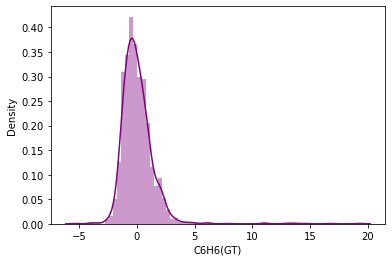

In [ ]:
sns.distplot((y_test-prediction), bins=70, color="purple")

In [ ]:
print('accuracy of your prediction is',end=' ')
print(r2_score(y_test,prediction)*100,end='')
print(' %')

accuracy of your prediction is 96.38182667757059 %


In [ ]:
y_test

6553     8.9
6594     6.2
7070     6.2
8826    10.1
582      7.8
        ... 
6260    27.2
4657    34.9
4932     6.3
724      6.3
4262    11.0
Name: C6H6(GT), Length: 1872, dtype: float64

In [ ]:
print("Coefficient for each feature:")
list(zip(X.columns, lr.coef_))

Coefficient for each feature:


[('CO(GT)', 0.39235829988104487),
 ('PT08.S1(CO)', 0.30915344007605583),
 ('PT08.S2(NMHC)', 10.705735475321521),
 ('NOx(GT)', 0.6752489143137888),
 ('PT08.S3(NOx)', 1.247210899075174),
 ('NO2(GT)', -0.7855963554566925),
 ('PT08.S4(NO2)', 0.4051184445840463),
 ('PT08.S5(O3)', 0.14501553346776563),
 ('T', -1.2976045856548137),
 ('RH', -0.84456635821055),
 ('AH', 0.6606106008353057)]

Now, we will do some kind of evaluation of our model. I decided to use some standard metrics: MAE, MSE, RMSE.

In [ ]:
print('MAE:',metrics.mean_absolute_error(y_test, prediction))
print('MSE:',metrics.mean_squared_error(y_test, prediction))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 0.9308510981343735
MSE: 2.179324967091657
RMSE: 1.4762536933371773


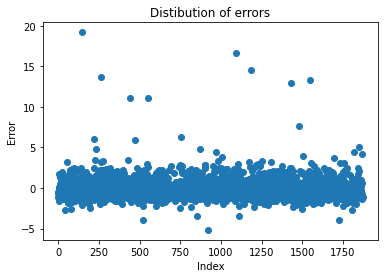

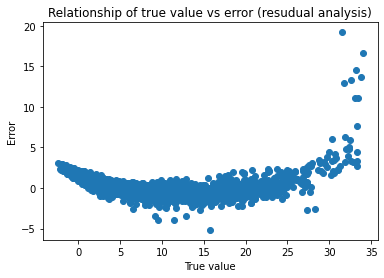

In [ ]:
#errors visualization
#can be helpful to better understand behavior of model

errors = y_test - prediction

plt.scatter(list(range(len(errors))),errors);
plt.title("Distibution of errors")
plt.ylabel('Error');
plt.xlabel('Index');
plt.show();

plt.scatter(prediction,errors);
plt.title('Relationship of true value vs error (resudual analysis)')
plt.ylabel('Error');
plt.xlabel('True value');
plt.show();

As we can see, the highest percentage of predicted values has an error approximately equal to zero, which means that the quality of the model is good.

#### Feature selection

Feature Selection is the method of reducing the input variable to your model by using only relevant data and getting rid of noise in data. In our case. we will check whether choosing a smaller set of features affects the quality of the model. We select the features using the obtained correlation.

In [ ]:
def evaluate_model(train, test, tr_y, tst_y, pipeline):
    pipeline.fit(train, tr_y)
    pred_test = pipeline.predict(test)
    pred_train = pipeline.predict(train)

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(metrics.mean_squared_error(tr_y, pred_train))],
        'train_R2': [r2_score(tr_y, pred_train)],
        'test_RMSE': [np.sqrt(metrics.mean_squared_error(tst_y, pred_test))],
        'test_R2': [r2_score(tst_y, pred_test)]
    })

The condition for selecting a feature is that the correlation between that feature and the target is greater than 0.5

In [ ]:
ind = np.abs(corrmat["C6H6(GT)"]) > 0.5
top_corr = corrmat["C6H6(GT)"][ind].index.tolist()
top_corr.remove("C6H6(GT)")

In [ ]:
pipeline = Pipeline([
    ('estimator', LinearRegression())
])

In [ ]:
scores = evaluate_model(x_train, x_test, y_train, y_test, pipeline)

In [ ]:
scores

train_RMSE  train_R2  test_RMSE   test_R2
0    1.312465    0.9695   1.476254  0.963818

We will repeat the previous model training procedure using the new data.

In [ ]:
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(X[top_corr], Y, test_size=.2, random_state=42)

In [ ]:
x_train_new=sc.fit_transform(x_train_new)
x_test_new=sc.transform(x_test_new)

In [ ]:
lr.fit(x_train_new, y_train_new)

LinearRegression()

In [ ]:
prediction_new = lr.predict(x_test_new)

In [ ]:
lr.score(x_train_new, y_train_new)

0.9683305918890377

In [ ]:
lr.score(x_test_new, y_test_new)

0.962417788552897

In [ ]:
print('accuracy of your prediction is',end=' ')
print(r2_score(y_test_new,prediction_new)*100,end='')
print(' %')

accuracy of your prediction is 96.2417788552897 %


In [ ]:
print('MAE:',metrics.mean_absolute_error(y_test_new, prediction_new))
print('MSE:',metrics.mean_squared_error(y_test_new, prediction_new))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test_new, prediction_new)))

MAE: 0.9337300404546394
MSE: 2.2636796091956017
RMSE: 1.504552959917198


The conclusion is that feature selection had no effect on improving the quality of the model, so we will use all features in the further analysis.

#### Hyperparameters tuning

Another way to improve the model is to tune the hyperparameters and search for the optimal combination of them. I will choose some range of values and try to use GridSearchCV in that range to find the best combination from that range.

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
pipeline = Pipeline([
    ('estimator', ElasticNet(random_state=42))
])
grid = {
    'estimator__alpha': np.linspace(0, 200, 1),
    'estimator__l1_ratio': np.arange(0, 1.1, 0.01)
}

gs = GridSearchCV(pipeline, grid,
                  n_jobs=-1,
                  scoring=['neg_mean_squared_error', 'r2'],
                  refit='neg_mean_squared_error',
                  cv=cv)

In [ ]:
%%time
gs.fit(x_train, y_train);

Wall time: 1min 8s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('estimator',
                                        ElasticNet(random_state=42))]),
             n_jobs=-1,
             param_grid={'estimator__alpha': array([0.]),
                         'estimator__l1_ratio': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27...
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09])},
             refit='neg_mean_squared_error',
  

In [ ]:
gs.best_params_

{'estimator__alpha': 0.0, 'estimator__l1_ratio': 0.0}

For the obtained parameters, we will calculate the score of the model over the train and test set

In [ ]:
pipeline = clone(pipeline)
pipeline.set_params(**gs.best_params_);

In [ ]:
scores = evaluate_model(x_train, x_test, y_train, y_test, pipeline)
scores

train_RMSE  train_R2  test_RMSE   test_R2
0    1.312465    0.9695   1.476254  0.963818

In [ ]:
scores = evaluate_model(x_train_new, x_test_new, y_train_new, y_test_new, pipeline)
scores

train_RMSE  train_R2  test_RMSE   test_R2
0    1.337383  0.968331   1.504553  0.962418

If we compare the results, even with the tuned model we get a better score for the data set that contains all columns and not feature selection.